# Proyecto de Machine Learning - Reconocimiento de Actividad Humana (HAR)
## MLEA 2025-II - qwertylab.dev

**Integrantes:** 
*   Oscar A. Virguez

**Propósito del Notebook:**
El presente documento detalla el flujo de trabajo seguido para realizar una solución al desafío, abarcando:

1.  **Análisis Exploratorio de Datos (EDA):** Comprensión de la distribución de clases y características de las señales.
2.  **Preprocesamiento e Ingeniería de Características:** Limpieza de datos, normalización y extracción de atributos relevantes para mejorar el desempeño de los modelos.
3.  **Modelado Predictivo:** Entrenamiento y evaluación de diversos algoritmos (incluyendo XGBoost y otros enfoques de aprendizaje supervisado).
4.  **Optimización y Selección:** Ajuste de hiperparámetros y selección del modelo óptimo balanceando precisión (*accuracy*) y eficiencia computacional.
5.  **Generación de Resultados:** Producción del archivo de predicciones para la competencia.

## Prerrequisitos

Para la correcta ejecución de este cuaderno, es necesario contar con las siguientes librerías instaladas en el entorno de Python:

*   `pandas`: Manipulación y análisis de datos.
*   `numpy`: Operaciones matemáticas y manejo de arrays.
*   `xgboost`: Algoritmo de Gradient Boosting para modelado.
*   `scikit-learn`: Herramientas de aprendizaje automático y métricas.
*   `matplotlib` & `seaborn`: Visualización de datos.

Puede instalar todas las dependencias ejecutando la siguiente celda.

In [51]:
%pip install pandas numpy xgboost scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Variables Globales

A continuación se definen las constantes globales utilizadas en el proyecto, incluyendo la semilla aleatoria para reproducibilidad y el nombre del directorio de datos.

In [52]:
# Definición de variables globales
SEED = 3141
FOLDER_NAME = "mlea-challenge-2025-ii-ue"  # Directorio para los datos y nombre de la competencia

print(f"Semilla global definida: {SEED}")
print(f"Directorio de datos definido: {FOLDER_NAME}")

Semilla global definida: 3141
Directorio de datos definido: mlea-challenge-2025-ii-ue


## 1. Carga de Datos

Se procede a la carga de los conjuntos de datos. Los datos se descargarán automáticamente desde el repositorio público del curso en GitHub si no se encuentran disponibles localmente.

In [53]:
import os
import urllib.request

os.makedirs(FOLDER_NAME, exist_ok=True)
BASE_URL = "https://raw.githubusercontent.com/oscar243/mlea/main/mlea-challenge-2025-ii-ue/"
FILES = ["metadata.csv", "signals.csv", "metadata_test.csv", "signals_test.csv", "metadata_kaggle.csv", "signals_kaggle.csv", "predictions_sample.csv"]

for file in FILES:
    path = os.path.join(FOLDER_NAME, file)
    if not os.path.exists(path):
        print(f"Descargando {file}...")
        try:
            urllib.request.urlretrieve(BASE_URL + file, path)
        except Exception as e:
            print(f"Error descargando {file}: {e}")

print("Carga de datos completada." if all(os.path.exists(os.path.join(FOLDER_NAME, f)) for f in FILES) else "Advertencia: Faltan archivos.")

Carga de datos completada.


## 2. Unificación de Datos

En esta etapa, se cargan todos los archivos CSV (entrenamiento, prueba y kaggle) tanto de señales como de metadatos. Se crea una columna `data_source` para identificar el origen de cada registro y posteriormente se fusionan en un único DataFrame maestro. Esto facilita el preprocesamiento conjunto y la generación de características consistentes.

In [54]:
import pandas as pd

# Cargar archivos de señales
signals_train = pd.read_csv(os.path.join(FOLDER_NAME, 'signals.csv'))
signals_test = pd.read_csv(os.path.join(FOLDER_NAME, 'signals_test.csv'))
signals_kaggle = pd.read_csv(os.path.join(FOLDER_NAME, 'signals_kaggle.csv'))

# Cargar archivos de metadatos
metadata_train = pd.read_csv(os.path.join(FOLDER_NAME, 'metadata.csv'))
metadata_test = pd.read_csv(os.path.join(FOLDER_NAME, 'metadata_test.csv'))
metadata_kaggle = pd.read_csv(os.path.join(FOLDER_NAME, 'metadata_kaggle.csv'))

# Etiquetar la fuente de datos
signals_train['data_source'] = 'train'
signals_test['data_source'] = 'test'
signals_kaggle['data_source'] = 'kaggle'

metadata_train['data_source'] = 'train'
metadata_test['data_source'] = 'test'
metadata_kaggle['data_source'] = 'kaggle'

# Concatenar todos los conjuntos
all_signals = pd.concat([signals_train, signals_test, signals_kaggle], ignore_index=True)
all_metadata = pd.concat([metadata_train, metadata_test, metadata_kaggle], ignore_index=True)

# Fusionar señales y metadatos usando 'user_snippet' y 'data_source'
unified_data = pd.merge(all_signals, all_metadata, on=['user_snippet', 'data_source'], how='left')

# Verificación de la carga
print(f"Dimensiones del dataset unificado: {unified_data.shape}")
print("\nPrimeras filas del dataset:")
display(unified_data.head())

print("\nDistribución de registros por fuente de datos:")
print(unified_data['data_source'].value_counts())

Dimensiones del dataset unificado: (1073323, 37)

Primeras filas del dataset:


user_snippet  x-axis  y-axis  z-axis  timestamp data_source  \
0        525_0    1.57   -0.61   -0.65        0.0       train   
1        525_0   -1.12    1.84   -1.46       50.0       train   
2        525_0    5.48   14.14   -5.71      100.0       train   
3        525_0  -12.41   10.53   -5.52      150.0       train   
4        525_0   -1.14   10.50    2.91      200.0       train   

   x-axis__sum_values  x-axis__median  x-axis__mean  x-axis__length  ...  \
0             -247.31          -1.805       -2.4731           100.0  ...   
1             -247.31          -1.805       -2.4731           100.0  ...   
2             -247.31          -1.805       -2.4731           100.0  ...   
3             -247.31          -1.805       -2.4731           100.0  ...   
4             -247.31          -1.805       -2.4731           100.0  ...   

   z-axis__median  z-axis__mean  z-axis__length  z-axis__standard_deviation  \
0           -1.44       -2.2178           100.0                    3.088071   
1           -1.44       -2.2178           100.0                    3.088071   
2           -1.44       -2.2178           100.0                    3.088071   
3           -1.44       -2.2178           100.0                    3.088071   
4           -1.44       -2.2178           100.0                    3.088071   

   z-axis__variance  z-axis__root_mean_square  z-axis__maximum  \
0          9.536183                  3.801949             2.91   
1          9.536183                  3.801949             2.91   
2          9.536183                  3.801949             2.91   
3          9.536183                  3.801949             2.91   
4          9.536183                  3.801949             2.91   

   z-axis__absolute_maximum  z-axis__minimum  activity  
0                     12.95           -12.95   Jogging  
1                     12.95           -12.95   Jogging  
2                     12.95           -12.95   Jogging  
3                     12.95           -12.95   Jogging  
4                     12.95           -12.95   Jogging  

[5 rows x 37 columns]


Distribución de registros por fuente de datos:
data_source
train     629866
kaggle    250184
test      193273
Name: count, dtype: int64


## 3. Análisis Exploratorio de Datos (EDA)

En esta sección, realizaremos un análisis visual para comprender mejor la naturaleza de los datos. Nos enfocaremos en tres aspectos clave:
1.  **Balance de Clases:** Verificar la distribución de las actividades en el conjunto de entrenamiento.
2.  **Visualización de Señales:** Observar el comportamiento de las series de tiempo (acelerómetro en ejes x, y, z) para cada tipo de actividad.
3.  **Correlación de Metadatos:** Analizar las relaciones entre las características estadísticas extraídas para identificar redundancias.

/tmp/ipykernel_1101212/1739816641.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data[['user_snippet', 'activity']].drop_duplicates(), x='activity', palette=activity_palette)


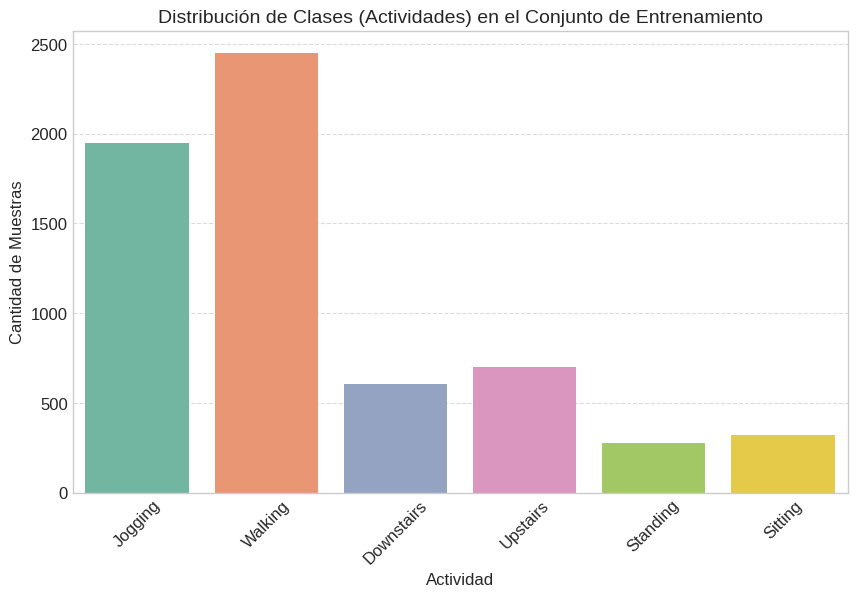

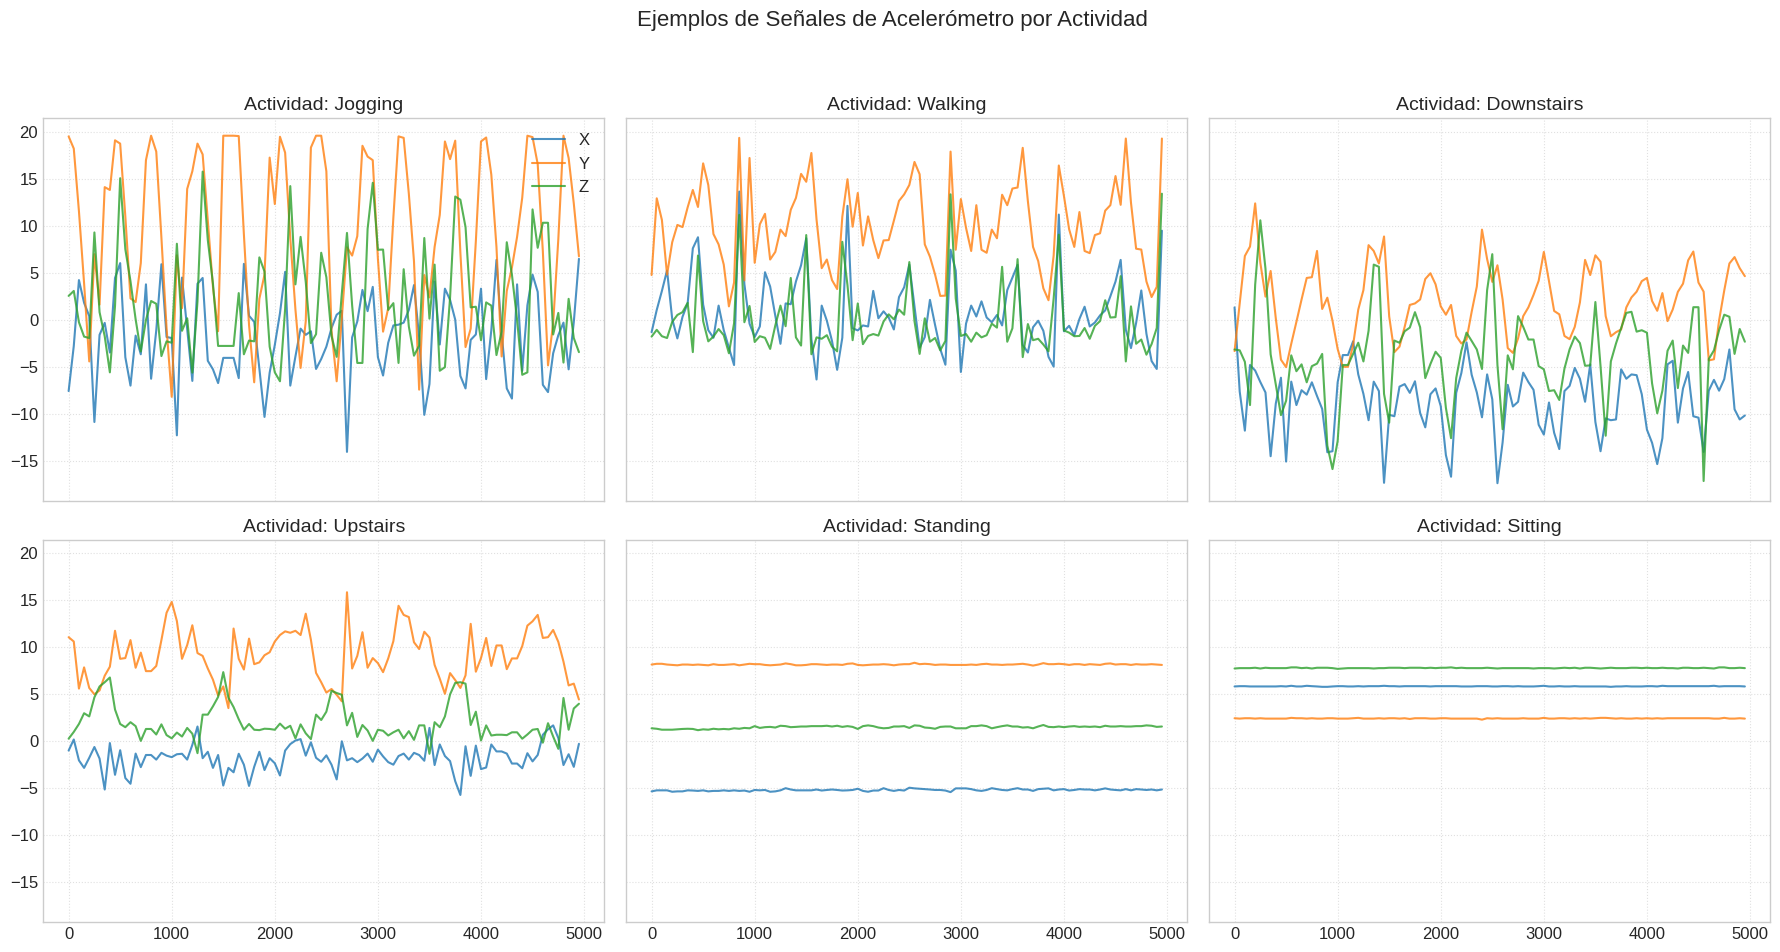

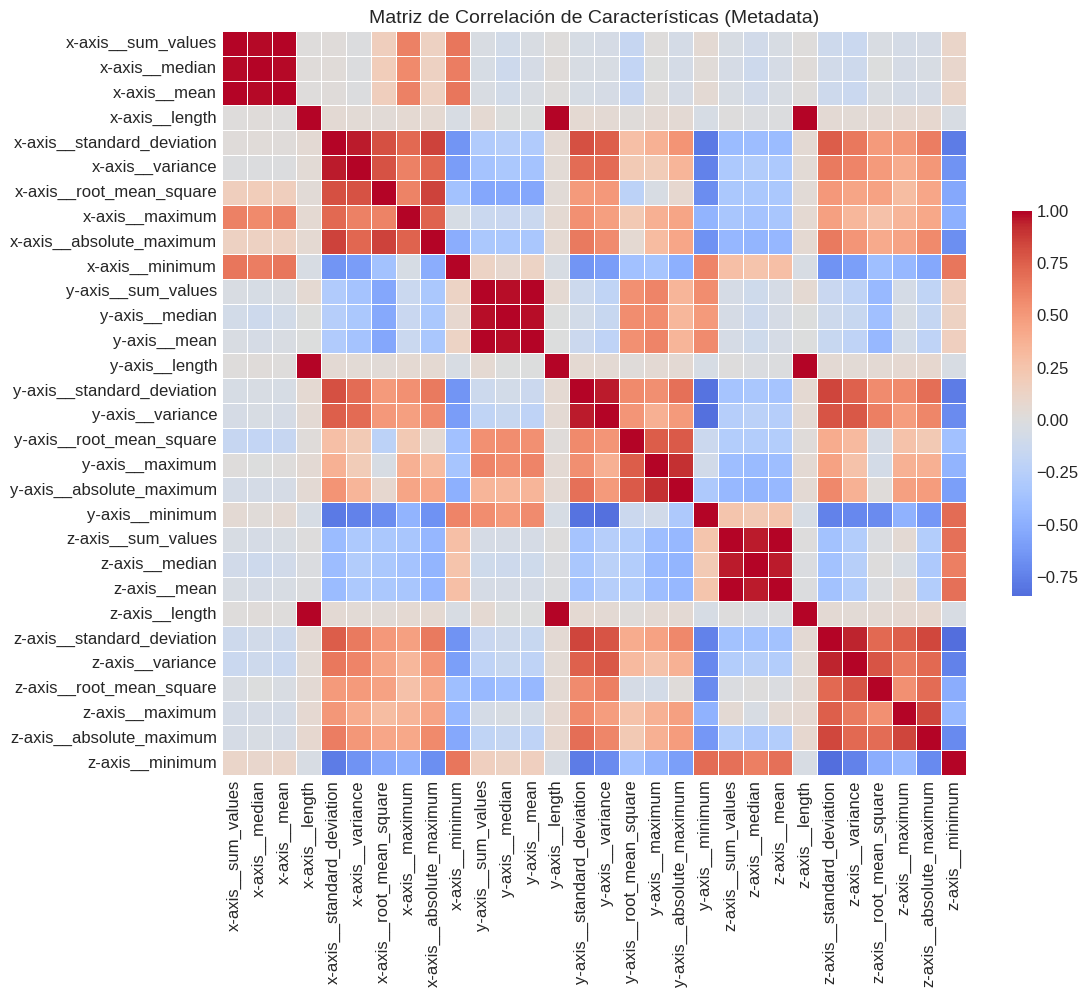

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Asegurar que existe el directorio de plots
os.makedirs('plots', exist_ok=True)

# Filtrar datos de entrenamiento para el análisis
train_data = unified_data[unified_data['data_source'] == 'train']

# Definir paleta cualitativa consistente para actividades (Set2 es buena para categorías)
# Se usará esta paleta en todas las gráficas que comparen actividades
activity_palette = "Set2"

# 1. Visualización de Clases (Balance)
plt.figure(figsize=(10, 6))
# Usamos la paleta cualitativa definida
sns.countplot(data=train_data[['user_snippet', 'activity']].drop_duplicates(), x='activity', palette=activity_palette)
plt.title('Distribución de Clases (Actividades) en el Conjunto de Entrenamiento')
plt.xlabel('Actividad')
plt.ylabel('Cantidad de Muestras')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('plots/class_distribution.png')
plt.show()

# 2. Visualización de Señales (Small Multiples)
activities = train_data['activity'].unique()
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, activity in enumerate(activities):
    # Seleccionar un snippet aleatorio para esta actividad
    snippet = train_data[train_data['activity'] == activity]['user_snippet'].sample(1, random_state=SEED).iloc[0]
    snippet_data = train_data[train_data['user_snippet'] == snippet].sort_values('timestamp')
    
    # Graficar ejes - Colores fijos para ejes (X, Y, Z) para mantener consistencia semántica
    axes[i].plot(snippet_data['timestamp'], snippet_data['x-axis'], label='X', alpha=0.8)
    axes[i].plot(snippet_data['timestamp'], snippet_data['y-axis'], label='Y', alpha=0.8)
    axes[i].plot(snippet_data['timestamp'], snippet_data['z-axis'], label='Z', alpha=0.8)
    
    axes[i].set_title(f'Actividad: {activity}')
    axes[i].grid(True, linestyle=':', alpha=0.6)
    if i == 0:
        axes[i].legend(loc='upper right')

plt.suptitle('Ejemplos de Señales de Acelerómetro por Actividad', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('plots/signals_examples.png')
plt.show()

# 3. Análisis de Metadata (Matriz de Correlación)
# Seleccionar columnas numéricas de metadatos (excluyendo identificadores y señales crudas)
metadata_cols = [col for col in train_data.columns if 'axis' in col and col not in ['x-axis', 'y-axis', 'z-axis']]

# Calcular correlación
corr_matrix = metadata_train[metadata_cols].corr()

plt.figure(figsize=(12, 10))
# Usamos 'coolwarm' (divergente) centrada en 0 para correlaciones, como indica la guía
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Matriz de Correlación de Características (Metadata)')
plt.savefig('plots/correlation_matrix.png')
plt.show()

**Verificación de Calidad de Datos: Consistencia de Longitud de Secuencias**

En este dataset, se espera que cada *snippet* contenga exactamente **100 muestras** (correspondientes a 5 segundos de grabación a 20 Hz).

A continuación, realizamos una auditoría de calidad en los tres conjuntos de datos (`train`, `test`, `kaggle`) para:
1.  Verificar que la mayoría de los *snippets* cumplan con la longitud estándar (100).
2.  Identificar valores atípicos (secuencias muy cortas o largas).
3.  Determinar si las irregularidades están asociadas a actividades específicas (en el caso de `train`).

In [56]:
# Función para analizar la consistencia de longitud en un dataset dado
def analyze_sequence_consistency(df, dataset_name):
    print(f"\n{'='*40}\nANÁLISIS DE LONGITUD: {dataset_name}\n{'='*40}")
    
    if df.empty:
        print("Dataset vacío.")
        return

    snippet_lengths = df.groupby('user_snippet').size()

    # Crear rangos (bins) para agrupar las longitudes
    bins = [0, 50, 90, 99, 100, np.inf]
    labels = ['0-50', '51-90', '91-99', '100', '>100']

    # Clasificar las longitudes en los rangos
    length_categories = pd.cut(snippet_lengths, bins=bins, labels=labels, right=True)

    # Calcular frecuencias y porcentajes
    summary_table = length_categories.value_counts().sort_index().reset_index()
    summary_table.columns = ['Rango de Longitud', 'Snippets']
    summary_table['%'] = (summary_table['Snippets'] / len(snippet_lengths) * 100).round(2)
    summary_table = summary_table[summary_table['Snippets'] > 0]

    display(summary_table)
    print(f"Longitud Mínima: {snippet_lengths.min()} | Máxima: {snippet_lengths.max()}")

    # Identificar snippets irregulares
    abnormal_mask = snippet_lengths != 100
    abnormal_snippets = snippet_lengths[abnormal_mask].index

    if len(abnormal_snippets) > 0:
        print(f"\n-> {len(abnormal_snippets)} snippets con longitud != 100")
        
        # Verificar si tenemos etiquetas de actividad (train) o no (test/kaggle)
        has_activity = 'activity' in df.columns and df['activity'].notna().any()
        
        if has_activity:
            print("Detalle por Actividad y Rango:")
            abnormal_data = df[df['user_snippet'].isin(abnormal_snippets)][['user_snippet', 'activity']].drop_duplicates()
            abnormal_data['length'] = abnormal_data['user_snippet'].map(snippet_lengths)
            abnormal_data['Rango'] = pd.cut(abnormal_data['length'], bins=bins, labels=labels, right=True)
            
            detailed = abnormal_data.groupby(['activity', 'Rango'], observed=True).size().reset_index(name='Cantidad')
            pivot = detailed.pivot(index='activity', columns='Rango', values='Cantidad').fillna(0).astype(int)
            if '100' in pivot.columns: pivot = pivot.drop(columns=['100'])
            display(pivot)
        else:
            print("(No hay etiquetas de actividad disponibles para desglosar en este conjunto)")
            # Mostrar desglose solo por rango
            abnormal_lengths = snippet_lengths[abnormal_mask]
            ranges = pd.cut(abnormal_lengths, bins=bins, labels=labels, right=True).value_counts().sort_index()
            ranges = ranges[ranges > 0].to_frame(name='Cantidad Snippets Irregulares')
            display(ranges)
    else:
        print("-> Consistencia perfecta (todos los snippets tienen 100 muestras).")

# Ejecutar análisis para Train, Test y Kaggle
for source in ['train', 'test', 'kaggle']:
    subset = unified_data[unified_data['data_source'] == source]
    analyze_sequence_consistency(subset, source.upper())


ANÁLISIS DE LONGITUD: TRAIN


Rango de Longitud  Snippets      %
0              0-50         9   0.14
1             51-90        12   0.19
2             91-99         1   0.02
3               100      6288  99.65

Longitud Mínima: 3 | Máxima: 100

-> 22 snippets con longitud != 100
Detalle por Actividad y Rango:


Rango       0-50  51-90  91-99
activity                      
Downstairs     1      4      0
Jogging        2      2      0
Sitting        1      2      0
Standing       4      3      0
Upstairs       1      1      0
Walking        0      0      1


ANÁLISIS DE LONGITUD: TEST


Rango de Longitud  Snippets      %
1             51-90         5   0.26
2             91-99         1   0.05
3               100      1928  99.69

Longitud Mínima: 68 | Máxima: 100

-> 6 snippets con longitud != 100
Detalle por Actividad y Rango:


Rango       51-90  91-99
activity                
Downstairs      2      0
Jogging         1      1
Standing        2      0


ANÁLISIS DE LONGITUD: KAGGLE


Rango de Longitud  Snippets      %
0              0-50         4   0.16
1             51-90         3   0.12
2             91-99         1   0.04
3               100      2498  99.68

Longitud Mínima: 3 | Máxima: 100

-> 8 snippets con longitud != 100
(No hay etiquetas de actividad disponibles para desglosar en este conjunto)


Cantidad Snippets Irregulares
0-50                               4
51-90                              3
91-99                              1

**Nota:** Se observa que la gran mayoría de los *snippets* cumplen con la longitud estándar de 100 muestras, lo que resulta en variables de longitud constantes. Además, el análisis preliminar sugiere una alta correlación entre las métricas de tendencia central (media, mediana, suma) y una redundancia matemática entre la varianza y la desviación estándar.

### 3.1 Análisis de Orientación

Para verificar si la orientación del dispositivo varía entre muestras (efectos de rotación), visualizaremos los promedios de cada eje en un espacio tridimensional. Si actividades estáticas como "Standing" muestran una gran dispersión esférica en lugar de un clúster compacto, esto indicaría que la dirección de la gravedad cambia debido a la posición del sensor.

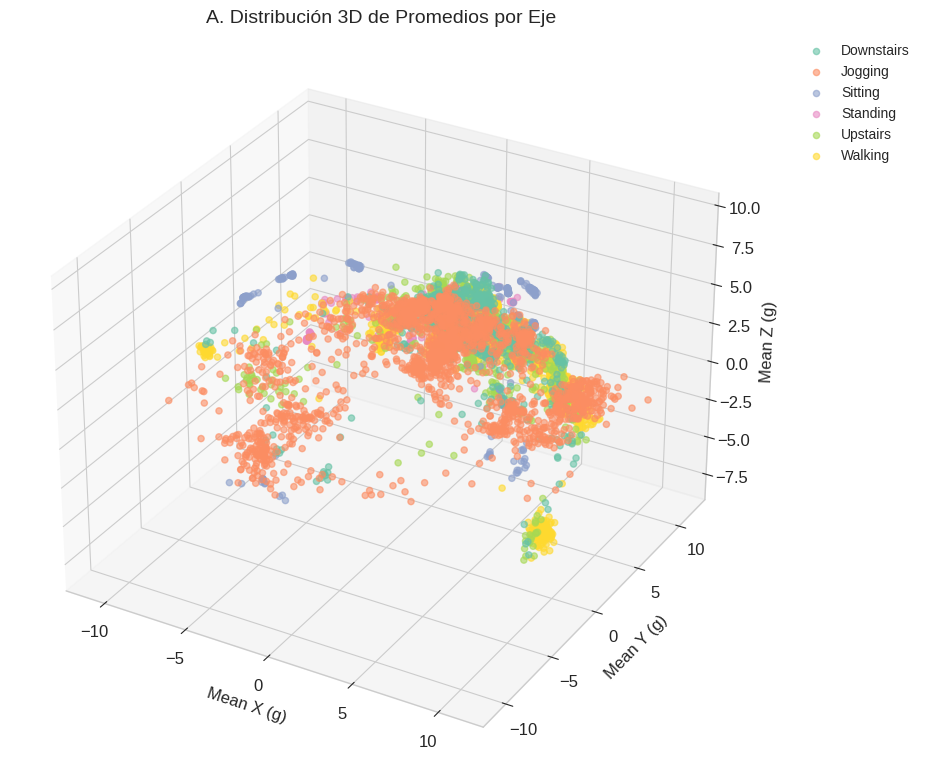

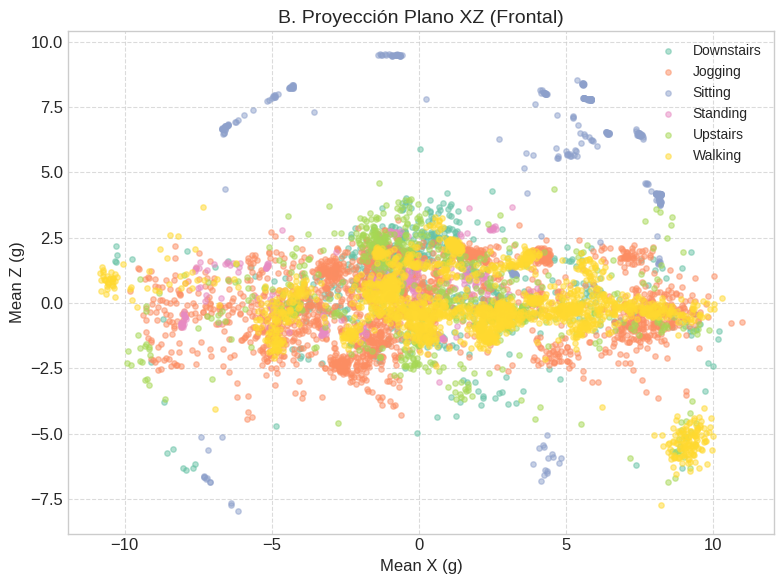

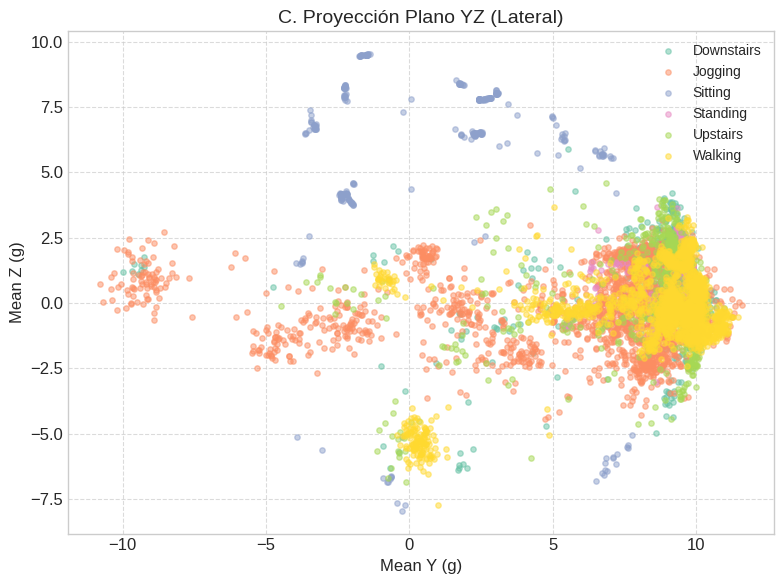

In [57]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Configuración de estilo para gráficos científicos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 12, 'figure.titlesize': 16, 'axes.titlesize': 14})

unique_activities = sorted(metadata_train['activity'].unique())
# Usar paleta cualitativa Set2 para categorías
colors = sns.color_palette("Set2", len(unique_activities))
activity_color_map = dict(zip(unique_activities, colors))

# 1. Vista 3D Principal
fig1 = plt.figure(figsize=(10, 8))
ax1 = fig1.add_subplot(111, projection='3d')

for activity in unique_activities:
    subset = metadata_train[metadata_train['activity'] == activity]
    ax1.scatter(subset['x-axis__mean'], subset['y-axis__mean'], subset['z-axis__mean'], 
                label=activity, color=activity_color_map[activity], alpha=0.6, s=20)

ax1.set_xlabel('Mean X (g)')
ax1.set_ylabel('Mean Y (g)')
ax1.set_zlabel('Mean Z (g)')
ax1.set_title('A. Distribución 3D de Promedios por Eje')
ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')
plt.tight_layout()
plt.savefig('plots/3d_orientation_distribution.png')
plt.show()

# 2. Proyección XZ (Vista Frontal) - Z en vertical
fig2, ax2 = plt.subplots(figsize=(8, 6))
for activity in unique_activities:
    subset = metadata_train[metadata_train['activity'] == activity]
    ax2.scatter(subset['x-axis__mean'], subset['z-axis__mean'], 
                label=activity, color=activity_color_map[activity], alpha=0.5, s=15)
ax2.set_xlabel('Mean X (g)')
ax2.set_ylabel('Mean Z (g)')
ax2.set_title('B. Proyección Plano XZ (Frontal)')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend(loc='upper right', fontsize='small')
plt.tight_layout()
plt.savefig('plots/xz_projection.png')
plt.show()

# 3. Proyección YZ (Vista Lateral) - Z en vertical
fig3, ax3 = plt.subplots(figsize=(8, 6))
for activity in unique_activities:
    subset = metadata_train[metadata_train['activity'] == activity]
    ax3.scatter(subset['y-axis__mean'], subset['z-axis__mean'], 
                label=activity, color=activity_color_map[activity], alpha=0.5, s=15)
ax3.set_xlabel('Mean Y (g)')
ax3.set_ylabel('Mean Z (g)')
ax3.set_title('C. Proyección Plano YZ (Lateral)')
ax3.grid(True, linestyle='--', alpha=0.7)
ax3.legend(loc='upper right', fontsize='small')
plt.tight_layout()
plt.savefig('plots/yz_projection.png')
plt.show()

#### 3.1.1 Análisis Específico: Actividad "Standing"

Para confirmar la hipótesis de que la orientación del dispositivo varía significativamente entre usuarios, aislaremos la actividad "Standing" (Estar de pie). En teoría, si el dispositivo estuviera siempre en la misma posición, la aceleración debida a la gravedad debería concentrarse en un solo eje (o una combinación constante). Si observamos una distribución esférica o dispersa, confirmaremos que el dispositivo se porta en diferentes orientaciones.

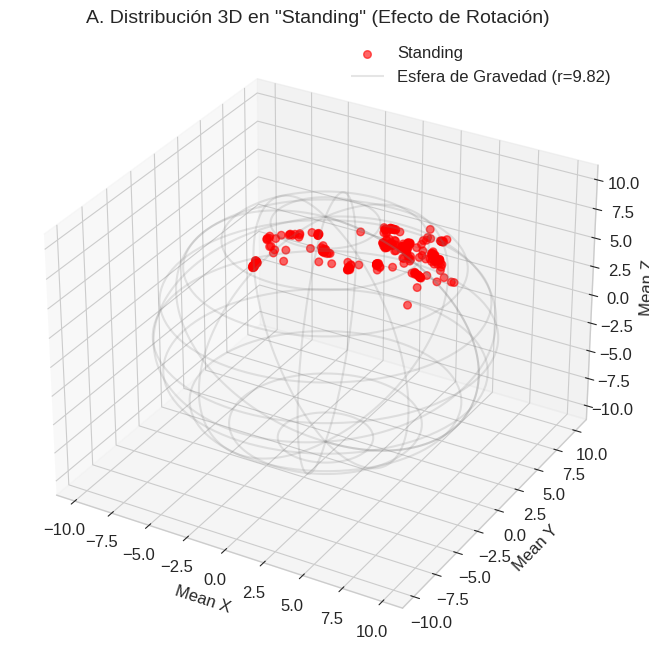

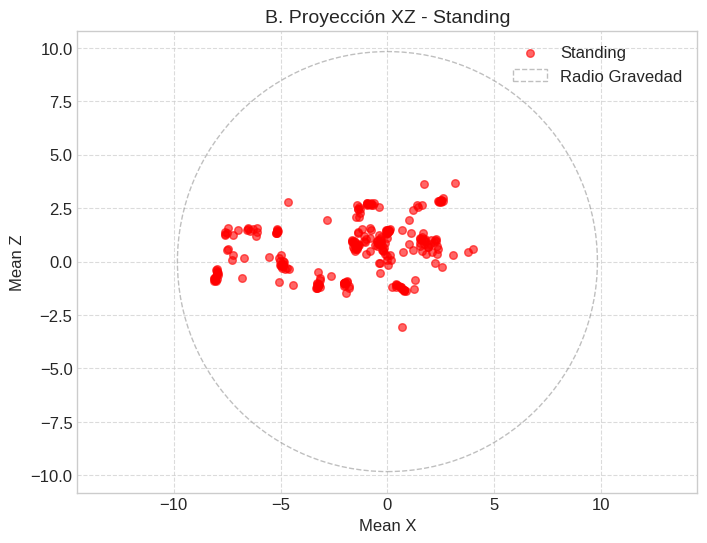

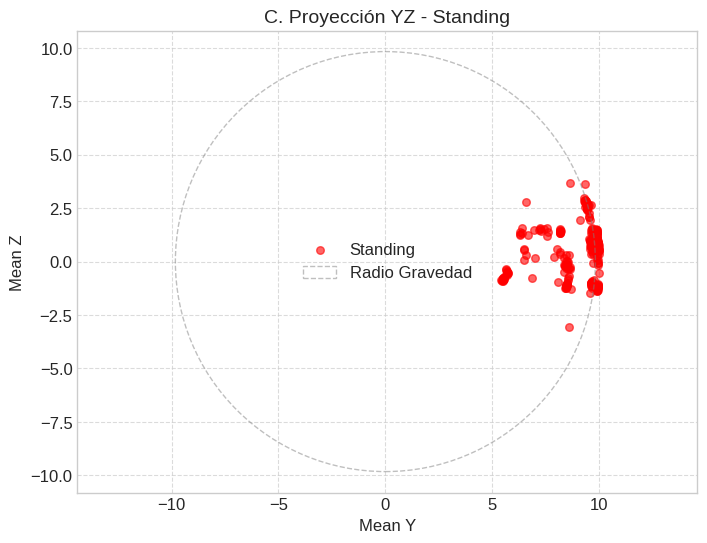

Magnitud promedio del vector de gravedad en 'Standing': 9.8226
Desviación estándar de la magnitud: 0.2736


In [58]:
# Filtrar solo la actividad 'Standing'
standing_data = metadata_train[metadata_train['activity'] == 'Standing']

# Calcular magnitud promedio para la esfera
magnitudes = np.sqrt(standing_data['x-axis__mean']**2 + standing_data['y-axis__mean']**2 + standing_data['z-axis__mean']**2)
avg_gravity = magnitudes.mean()

# 1. Vista 3D para Standing
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar puntos
ax.scatter(standing_data['x-axis__mean'], 
           standing_data['y-axis__mean'], 
           standing_data['z-axis__mean'], 
           c='red', alpha=0.6, s=30, label='Standing')

# Crear malla para la esfera
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = avg_gravity * np.outer(np.cos(u), np.sin(v))
y = avg_gravity * np.outer(np.sin(u), np.sin(v))
z = avg_gravity * np.outer(np.ones(np.size(u)), np.cos(v))

# Graficar esfera de referencia
ax.plot_wireframe(x, y, z, color='gray', alpha=0.2, rstride=10, cstride=10, label=f'Esfera de Gravedad (r={avg_gravity:.2f})')

ax.set_xlabel('Mean X')
ax.set_ylabel('Mean Y')
ax.set_zlabel('Mean Z')
ax.set_title('A. Distribución 3D en "Standing" (Efecto de Rotación)')
ax.legend()
plt.savefig('plots/3d_standing_gravity.png')
plt.show()

# 2. Proyección XZ para Standing - Z en vertical
fig2, ax2 = plt.subplots(figsize=(8, 6))
ax2.scatter(standing_data['x-axis__mean'], standing_data['z-axis__mean'], c='red', alpha=0.6, s=30, label='Standing')
# Círculo de referencia en 2D
circle = plt.Circle((0, 0), avg_gravity, color='gray', fill=False, linestyle='--', alpha=0.5, label='Radio Gravedad')
ax2.add_patch(circle)
ax2.set_xlabel('Mean X')
ax2.set_ylabel('Mean Z')
ax2.set_title('B. Proyección XZ - Standing')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend()
ax2.set_aspect('equal', adjustable='datalim')
plt.savefig('plots/xz_standing.png')
plt.show()

# 3. Proyección YZ para Standing - Z en vertical
fig3, ax3 = plt.subplots(figsize=(8, 6))
ax3.scatter(standing_data['y-axis__mean'], standing_data['z-axis__mean'], c='red', alpha=0.6, s=30, label='Standing')
# Círculo de referencia en 2D
circle = plt.Circle((0, 0), avg_gravity, color='gray', fill=False, linestyle='--', alpha=0.5, label='Radio Gravedad')
ax3.add_patch(circle)
ax3.set_xlabel('Mean Y')
ax3.set_ylabel('Mean Z')
ax3.set_title('C. Proyección YZ - Standing')
ax3.grid(True, linestyle='--', alpha=0.7)
ax3.legend()
ax3.set_aspect('equal', adjustable='datalim')
plt.savefig('plots/yz_standing.png')
plt.show()

print(f"Magnitud promedio del vector de gravedad en 'Standing': {avg_gravity:.4f}")
print(f"Desviación estándar de la magnitud: {magnitudes.std():.4f}")

#### 3.1.2 Uso de SVM (Signal Vector Magnitude)

El análisis anterior de la actividad "Standing" revela que, aunque el dispositivo tiende a mantener una orientación general, existen variaciones en la distribución de la gravedad entre los ejes (efectos de rotación). Para mitigar esto y extraer características invariantes a la rotación, utilizaremos la **Magnitud del Vector de Señal (SVM)**.

El SVM combina los tres ejes en una sola métrica de intensidad, descartando la información direccional y enfocándose puramente en la magnitud de la aceleración:

$$ SVM = \sqrt{x^2 + y^2 + z^2} $$

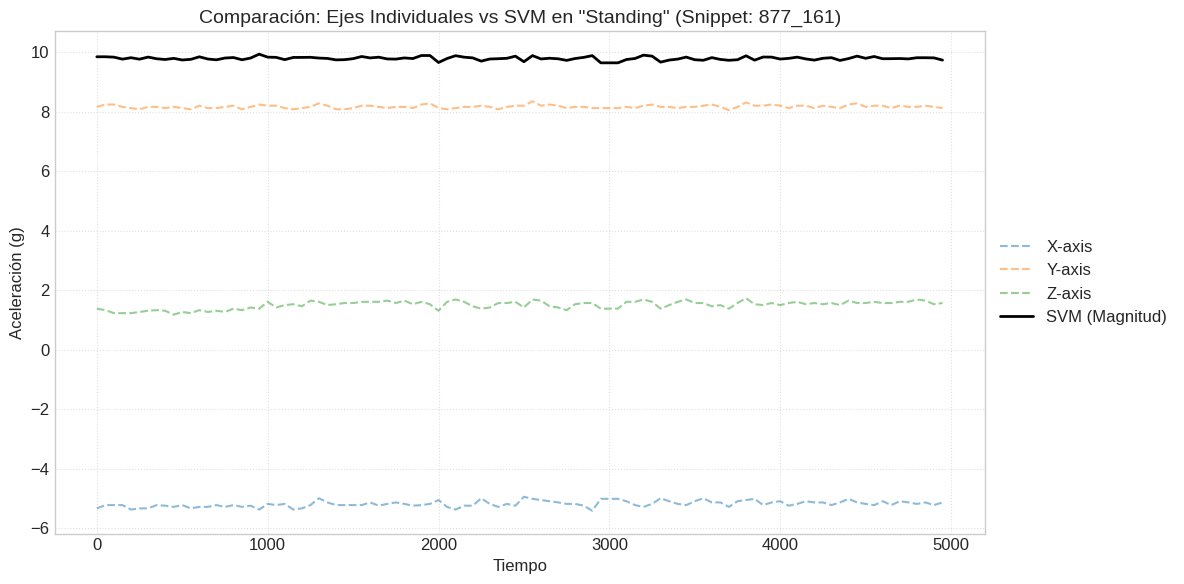

Desviación Estándar Promedio Ejes: 0.0959
Desviación Estándar SVM: 0.0574


In [59]:
# Visualización específica para Standing: Componentes vs SVM
# Objetivo: Demostrar cómo el SVM estabiliza la señal frente a rotaciones

# Seleccionar un snippet representativo de Standing
standing_snippet = train_data[train_data['activity'] == 'Standing']['user_snippet'].sample(1, random_state=SEED).iloc[0]
data_standing = train_data[train_data['user_snippet'] == standing_snippet].sort_values('timestamp')

# Calcular SVM
svm_standing = np.sqrt(data_standing['x-axis']**2 + data_standing['y-axis']**2 + data_standing['z-axis']**2)

plt.figure(figsize=(12, 6))

# Graficar componentes individuales
plt.plot(data_standing['timestamp'], data_standing['x-axis'], label='X-axis', alpha=0.5, linestyle='--')
plt.plot(data_standing['timestamp'], data_standing['y-axis'], label='Y-axis', alpha=0.5, linestyle='--')
plt.plot(data_standing['timestamp'], data_standing['z-axis'], label='Z-axis', alpha=0.5, linestyle='--')

# Graficar SVM
plt.plot(data_standing['timestamp'], svm_standing, label='SVM (Magnitud)', color='black', linewidth=2)

plt.title(f'Comparación: Ejes Individuales vs SVM en "Standing" (Snippet: {standing_snippet})')
plt.xlabel('Tiempo')
plt.ylabel('Aceleración (g)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.savefig('plots/components_vs_svm.png')
plt.show()

print(f"Desviación Estándar Promedio Ejes: {data_standing[['x-axis', 'y-axis', 'z-axis']].std().mean():.4f}")
print(f"Desviación Estándar SVM: {svm_standing.std():.4f}")

**Nota:** El análisis de orientación revela que, aunque los ejes mantienen cierta alineación general, existen variaciones notables entre muestras debido a la rotación del dispositivo. Utilizar la **Magnitud del Vector de Señal (SVM)** para obtener características invariantes a la posición del sensor puede ayudar a diferenciar mejor las senales que usar las componentes cartesianas. Los resultados sugieren que un sistema de coordenadas esféricas se adapta mejor a la física del movimiento (especialmente bajo la influencia constante de la gravedad), y que la amplitud (magnitud) resulta ser una variable más efectiva e interpretable, permitiendo capturar la intensidad de la actividad sin el ruido introducido por los cambios de dirección.

### 3.2 Análisis en el Dominio de la Frecuencia

Para el análisis en frecuencia se usará el SVM que usamos previamente para visualizar la aceleración constante de la gravedad.


En esta sección visualizamos la "huella digital" de cada actividad superponiendo múltiples señales de **Magnitud del Vector de Señal (SVM)**.
El SVM se calcula como:
$$ SVM = \sqrt{x^2 + y^2 + z^2} $$

Esto nos permite observar la varianza intra-clase y patrones periódicos característicos (ej. pasos en "Walking" vs ruido en "Sitting").

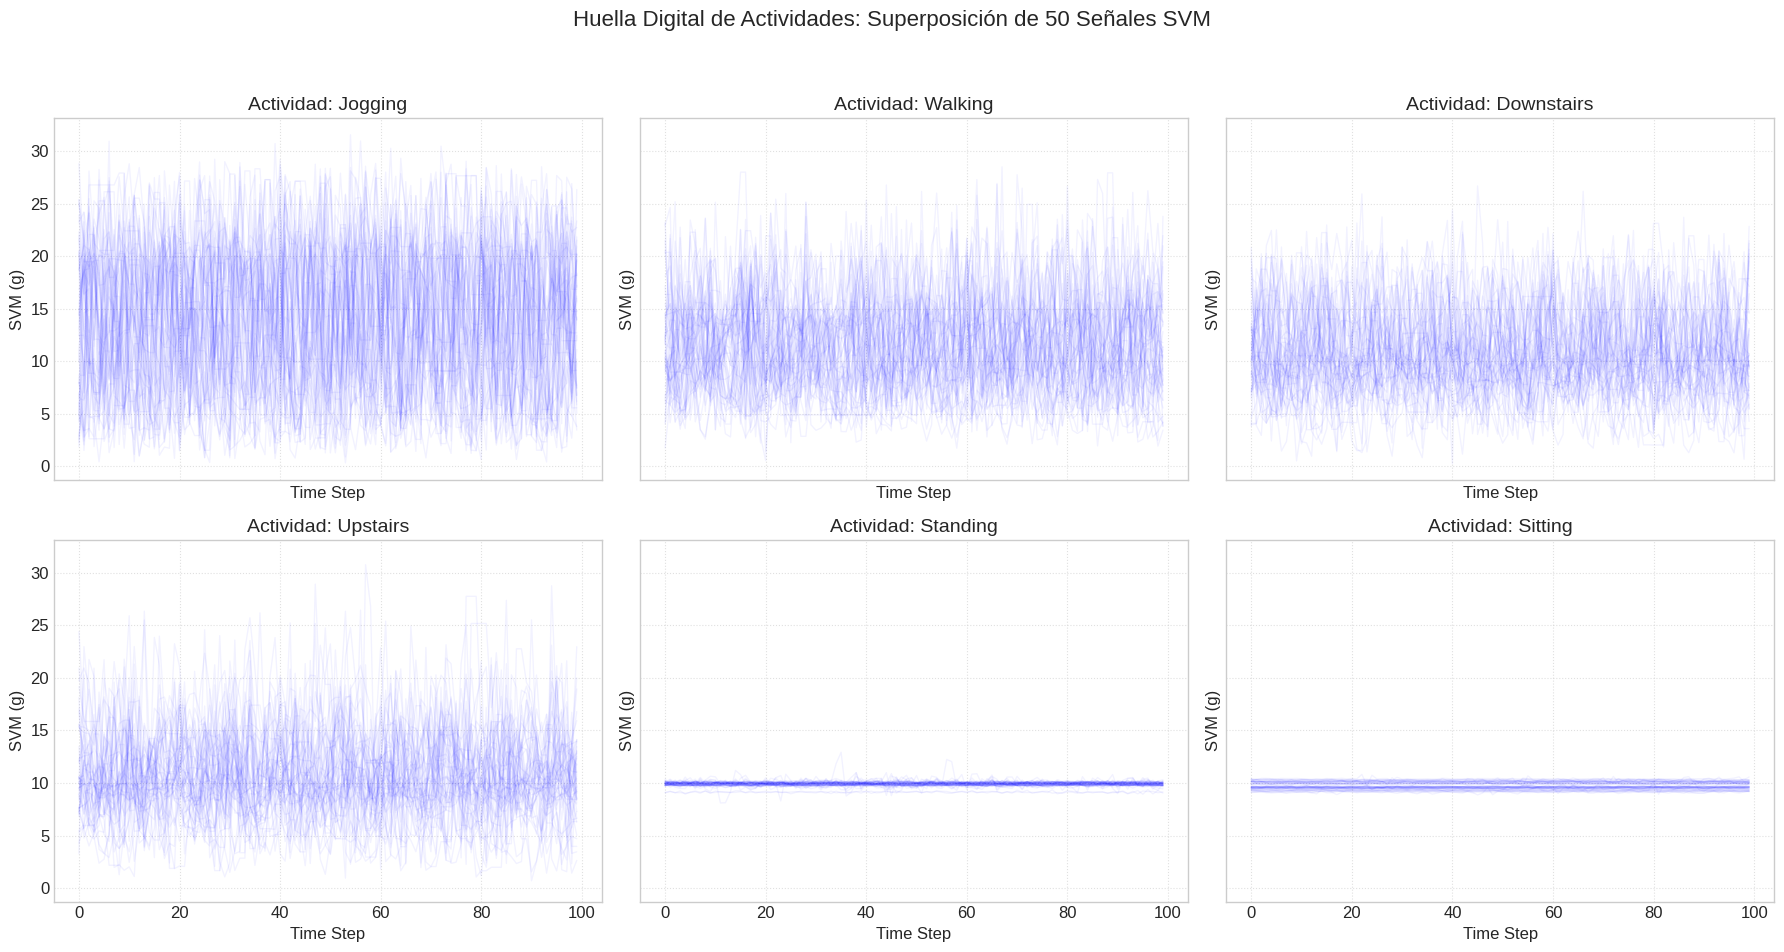

In [60]:
# Configuración de la figura
activities = train_data['activity'].unique()
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), sharex=True, sharey=True)
axes = axes.flatten()

# Iterar sobre cada actividad
for i, activity in enumerate(activities):
    # Seleccionar 50 snippets aleatorios para esta actividad (Más usuarios para ver la varianza)
    snippets = train_data[train_data['activity'] == activity]['user_snippet'].drop_duplicates().sample(50, random_state=SEED)
    
    # Graficar cada snippet
    for snippet in snippets:
        snippet_data = train_data[train_data['user_snippet'] == snippet].sort_values('timestamp')
        
        # Calcular SVM (Signal Vector Magnitude)
        svm = np.sqrt(snippet_data['x-axis']**2 + snippet_data['y-axis']**2 + snippet_data['z-axis']**2)
        
        # Normalizar tiempo para superponer (0 a N)
        time_steps = np.arange(len(svm))
        
        # Graficar
        axes[i].plot(time_steps, svm, color='blue', alpha=0.05, linewidth=1)
        
    axes[i].set_title(f'Actividad: {activity}')
    axes[i].set_xlabel('Time Step')
    axes[i].set_ylabel('SVM (g)')
    axes[i].grid(True, linestyle=':', alpha=0.6)

plt.suptitle('Huella Digital de Actividades: Superposición de 50 Señales SVM', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('plots/svm_fingerprint.png')
plt.show()


Tanto en las gráficas de SVM como en las visualizaciones de señales individuales, se aprecian comportamientos oscilatorios distintivos. Aparentemente algunas actividades presentan frecuencias de aceleración más altas que otras (ej. *Jogging* vs *Walking*). Por ello, se procede a realizar un análisis en el dominio de la frecuencia para identificar patrones espectrales y comprender mejor la composición de cada actividad.

A continuación, se abordarán:
1.  **Densidad Espectral de Potencia (PSD):** Comparación de los espectros promedio.
2.  **Espectrograma:** Análisis tiempo-frecuencia para detectar no-estacionariedades o envolventes.
3.  **Autocorrelación:** Análisis de la periodicidad de la señal.
4.  **Entropía Espectral:** Medida de desorden para distinguir actividades estáticas de dinámicas.

#### 3.2.1 Densidad Espectral de Potencia (PSD)


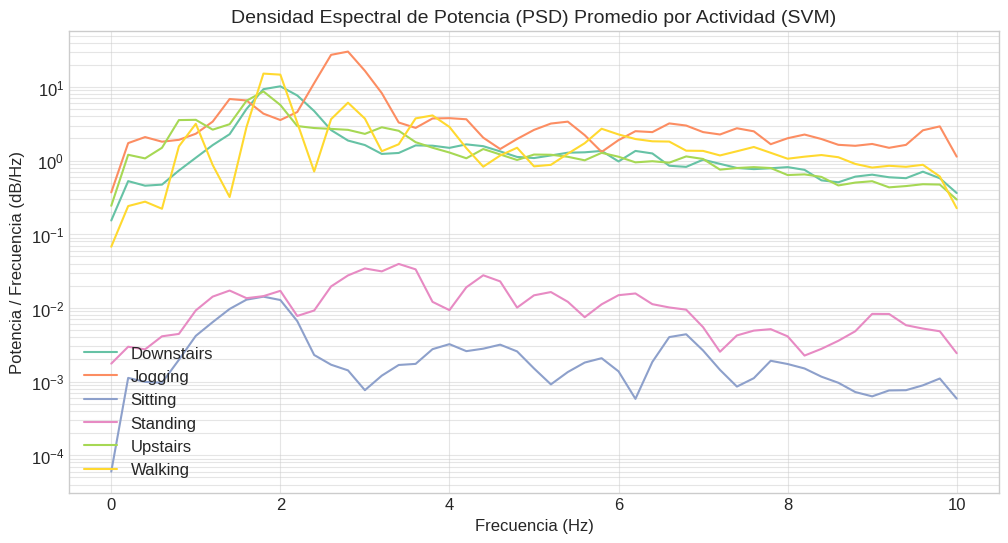

In [61]:
from scipy import signal

# Frecuencia de muestreo conocida
FS = 20.0  # Hz

# Calcular PSD promedio por actividad
plt.figure(figsize=(12, 6))

# Asegurar que usamos el mismo mapa de colores
unique_activities = sorted(train_data['activity'].unique())
colors = sns.color_palette("Set2", len(unique_activities))
activity_color_map = dict(zip(unique_activities, colors))

for activity in unique_activities:
    psd_list = []
    freqs = None
    
    # Tomar una muestra de snippets para no procesar todo si es muy grande
    snippets = train_data[train_data['activity'] == activity]['user_snippet'].unique()
    selected_snippets = np.random.choice(snippets, min(len(snippets), 50), replace=False)
    
    for snippet in selected_snippets:
        subset = train_data[train_data['user_snippet'] == snippet].sort_values('timestamp')
        # Calcular SVM
        svm = np.sqrt(subset['x-axis']**2 + subset['y-axis']**2 + subset['z-axis']**2)
        # Eliminar componente DC (gravedad)
        svm_detrend = svm - svm.mean()
        
        # Calcular Periodograma de Welch
        f, Pxx = signal.welch(svm_detrend, FS, nperseg=min(len(svm), 256))
        
        if freqs is None:
            freqs = f
        else:
            # Alinear todas las PSD a la misma malla de frecuencias para promediar
            if len(Pxx) != len(freqs):
                Pxx = np.interp(freqs, f, Pxx)
        
        psd_list.append(Pxx)
            
    # Promediar PSDs
    if psd_list:
        avg_psd = np.mean(psd_list, axis=0)
        # Usar el color correspondiente a la actividad
        plt.semilogy(freqs, avg_psd, label=activity, color=activity_color_map[activity])

plt.title('Densidad Espectral de Potencia (PSD) Promedio por Actividad (SVM)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Potencia / Frecuencia (dB/Hz)')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.savefig('plots/psd_average.png')
plt.show()

#### 3.2.2 Espectrograma (Análisis Tiempo-Frecuencia)

El espectrograma permite visualizar cómo varía el contenido frecuencial a lo largo del tiempo. En la superposición de señales anterior, se observaron posibles "envolventes" o variaciones de amplitud. Este análisis ayuda a determinar si la frecuencia es constante durante el *snippet* o si varía, lo cual es útil para detectar cambios de ritmo o confirmar la estacionariedad de la actividad.

Downstairs: len=153, nperseg=32, bins_t=9, Sxx shape=(17, 9), min=-34.68, max=12.14
Jogging: len=153, nperseg=32, bins_t=9, Sxx shape=(17, 9), min=-41.09, max=15.57
Sitting: len=153, nperseg=32, bins_t=9, Sxx shape=(17, 9), min=-75.35, max=-32.90
Standing: len=153, nperseg=32, bins_t=9, Sxx shape=(17, 9), min=-70.35, max=-26.28
Upstairs: len=153, nperseg=32, bins_t=9, Sxx shape=(17, 9), min=-25.95, max=5.46
Walking: len=153, nperseg=32, bins_t=9, Sxx shape=(17, 9), min=-24.53, max=12.15


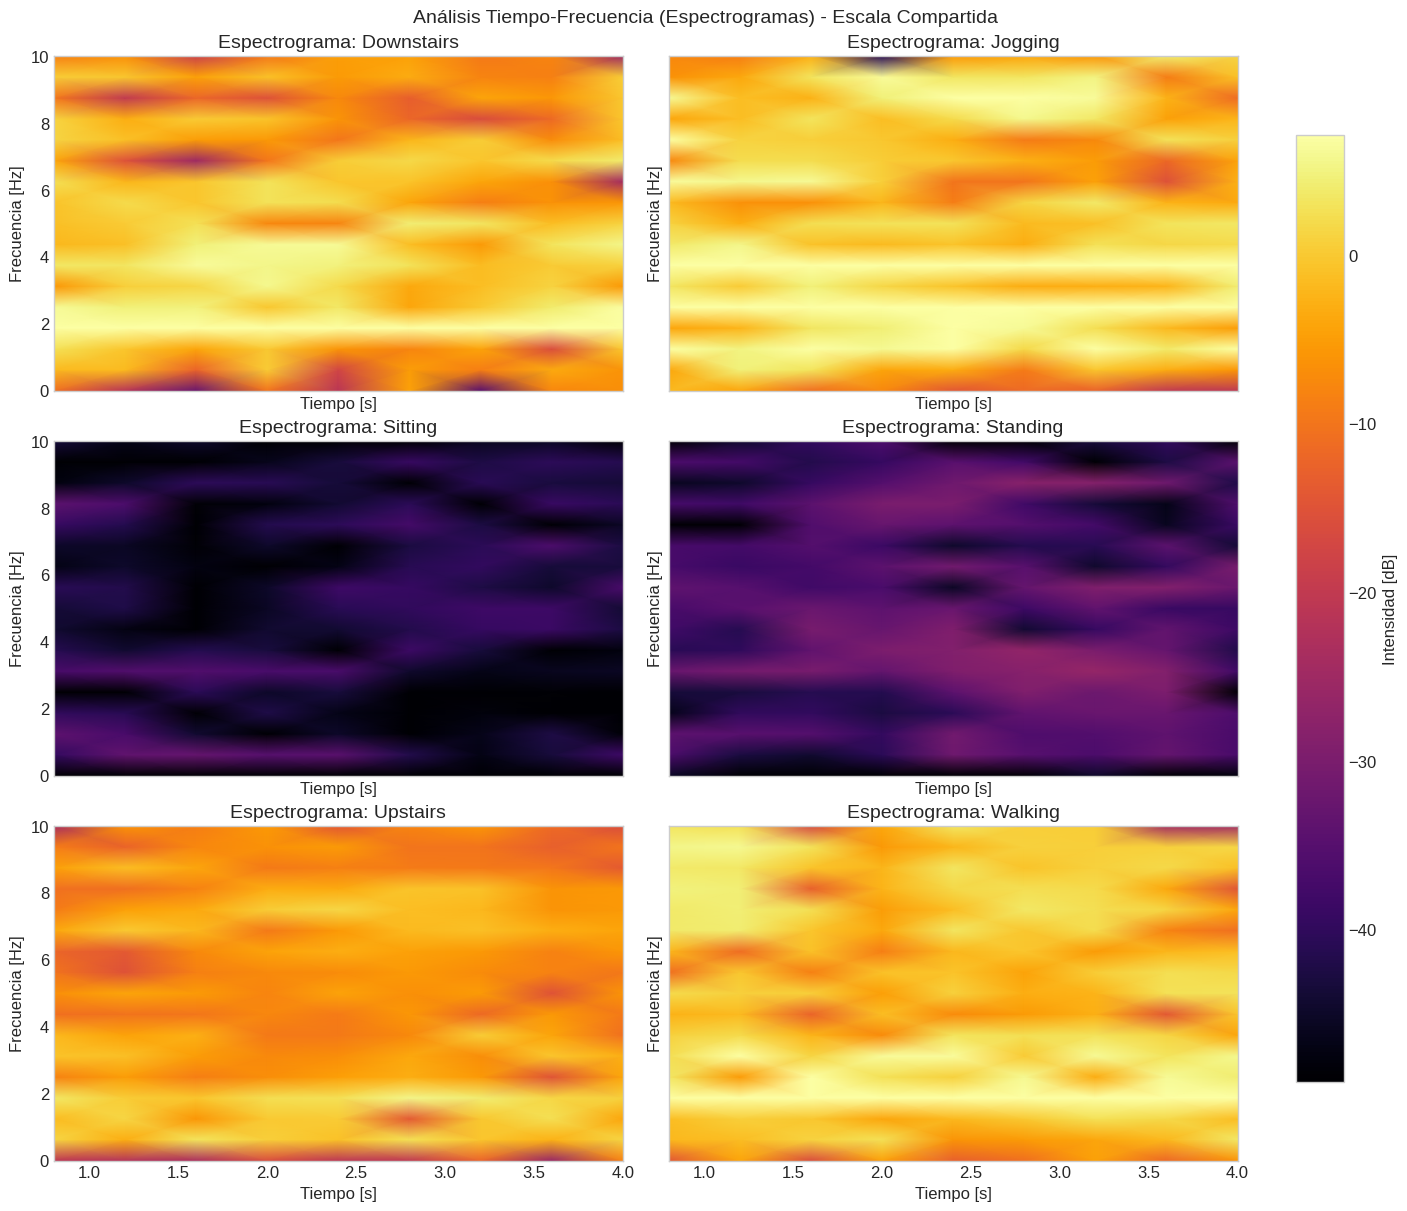

In [62]:
# Espectrogramas para las 6 actividades con la misma escala de color (layout 3x2)
demo_activities = sorted(train_data['activity'].unique())
fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharex=True, sharey=True, constrained_layout=True)
axes = axes.flatten()
spec_data = []
all_vals = []
for act in demo_activities:
    snippet = train_data[train_data['activity'] == act]['user_snippet'].sample(1, random_state=SEED).iloc[0]
    subset = train_data[train_data['user_snippet'] == snippet].sort_values('timestamp')
    svm = np.sqrt(subset['x-axis']**2 + subset['y-axis']**2 + subset['z-axis']**2)
    svm = svm - svm.mean()
    nperseg = min(32, len(svm))
    noverlap = max(0, nperseg - 8)
    f, t, Sxx = signal.spectrogram(svm, FS, nperseg=nperseg, noverlap=noverlap)
    Sxx_db = 10 * np.log10(Sxx + 1e-12)
    if np.isfinite(Sxx_db).any():
        all_vals.append(Sxx_db.flatten())
    spec_data.append({"act": act, "f": f, "t": t, "Sxx_db": Sxx_db, "nperseg": nperseg})
if all_vals:
    flat = np.concatenate(all_vals)
    vmin, vmax = np.nanpercentile(flat, [5, 95])
    if vmin == vmax:
        vmin = vmax - 10
else:
    vmin, vmax = -120, -60
ims = []
for i, entry in enumerate(spec_data):
    f, t, Sxx_db, act, nperseg = entry["f"], entry["t"], entry["Sxx_db"], entry["act"], entry["nperseg"]
    print(f"{act}: len={len(Sxx_db.flatten())}, nperseg={nperseg}, bins_t={len(t)}, Sxx shape={Sxx_db.shape}, min={np.nanmin(Sxx_db):.2f}, max={np.nanmax(Sxx_db):.2f}")
    im = axes[i].pcolormesh(t, f, Sxx_db, shading='gouraud', cmap='inferno', vmin=vmin, vmax=vmax)
    axes[i].set_title(f'Espectrograma: {act}')
    axes[i].set_ylabel('Frecuencia [Hz]')
    axes[i].set_xlabel('Tiempo [s]')
    axes[i].set_ylim(0, 10)
    axes[i].set_aspect('auto')
    ims.append(im)
# Único colorbar a la derecha, compartido
cbar = fig.colorbar(ims[-1], ax=axes, label='Intensidad [dB]', fraction=0.04, pad=0.04, location='right')
plt.suptitle('Análisis Tiempo-Frecuencia (Espectrogramas) - Escala Compartida', fontsize=14)
# plt.tight_layout(rect=[0, 0.03, 0.94, 0.97])
plt.savefig('plots/spectrograms_shared.png')
plt.show()

**Análisis Diferenciado de Espectrogramas**

Dado que la escala de intensidad espectral difiere significativamente entre actividades estáticas (*Sitting*, *Standing*) y dinámicas, se procede a realizar el análisis de espectrogramas por separado para cada grupo. Esto permite una visualización más detallada de los patrones frecuenciales específicos de cada tipo de actividad sin que la escala de color se vea sesgada por los valores extremos de las actividades más intensas.

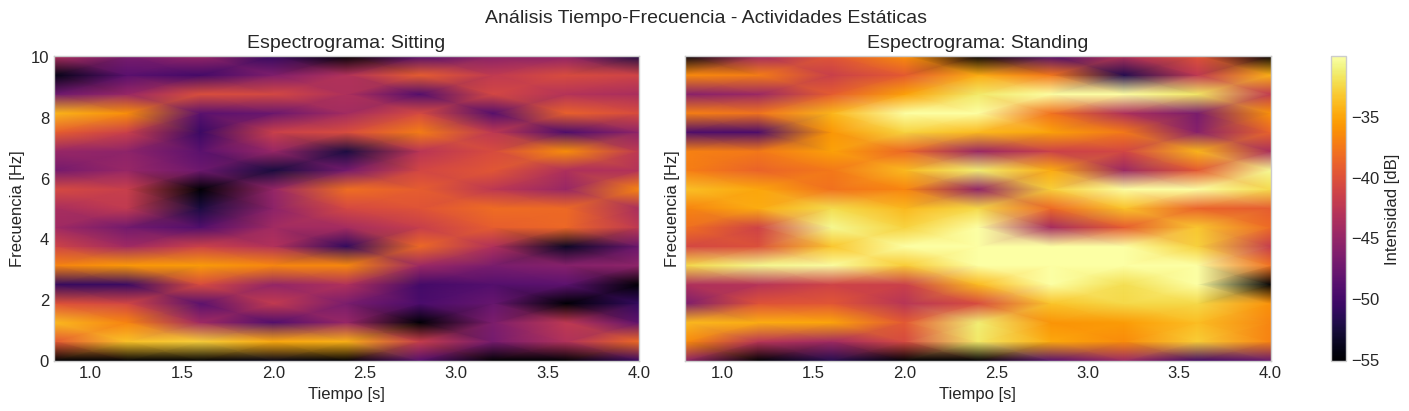

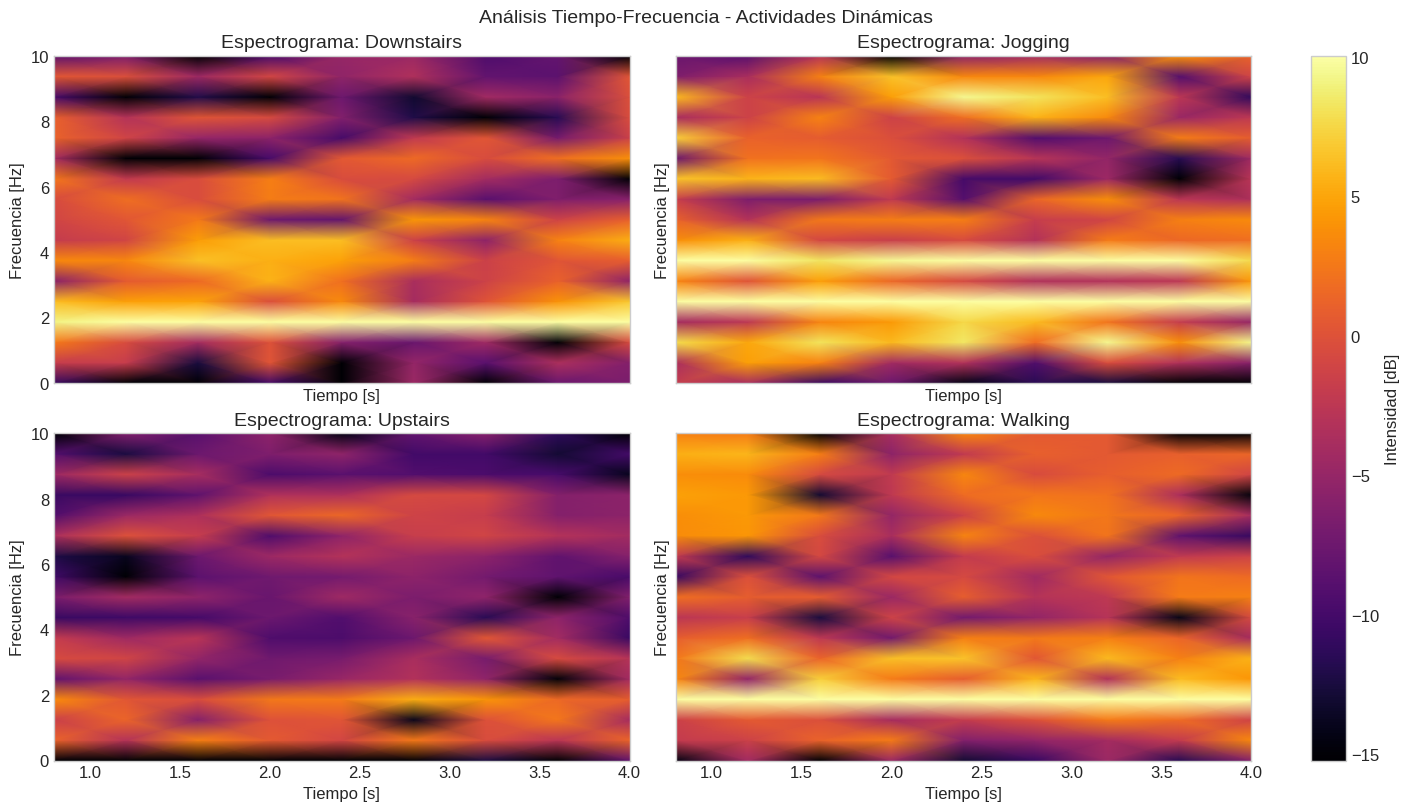

In [63]:
# Separación de actividades en estáticas y dinámicas
static_activities = ['Sitting', 'Standing']
dynamic_activities = [act for act in demo_activities if act not in static_activities]

def plot_spectrograms(activity_list, title_suffix):
    n_acts = len(activity_list)
    # Ajustar filas/columnas dinámicamente
    cols = 2
    rows = (n_acts + 1) // cols
    if rows == 0: rows = 1
    
    fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), sharex=True, sharey=True, constrained_layout=True)
    if n_acts > 1:
        axes = axes.flatten()
    else:
        axes = [axes] # Asegurar que sea iterable si solo hay 1
    
    spec_data = []
    all_vals = []
    
    for act in activity_list:
        # Obtener un snippet aleatorio
        snippet = train_data[train_data['activity'] == act]['user_snippet'].sample(1, random_state=SEED).iloc[0]
        subset = train_data[train_data['user_snippet'] == snippet].sort_values('timestamp')
        
        # Calcular SVM y eliminar DC
        svm = np.sqrt(subset['x-axis']**2 + subset['y-axis']**2 + subset['z-axis']**2)
        svm = svm - svm.mean()
        
        # Configuración del espectrograma
        nperseg = min(32, len(svm))
        noverlap = max(0, nperseg - 8)
        f, t, Sxx = signal.spectrogram(svm, FS, nperseg=nperseg, noverlap=noverlap)
        
        # Convertir a dB
        Sxx_db = 10 * np.log10(Sxx + 1e-12)
        
        if np.isfinite(Sxx_db).any():
            all_vals.append(Sxx_db.flatten())
        
        spec_data.append({"act": act, "f": f, "t": t, "Sxx_db": Sxx_db})
    
    # Calcular escala de color común para este grupo
    if all_vals:
        flat = np.concatenate(all_vals)
        vmin, vmax = np.nanpercentile(flat, [5, 95])
        if vmin == vmax:
            vmin = vmax - 10
    else:
        vmin, vmax = -120, -60
        
    ims = []
    for i, entry in enumerate(spec_data):
        f, t, Sxx_db, act = entry["f"], entry["t"], entry["Sxx_db"], entry["act"]
        
        im = axes[i].pcolormesh(t, f, Sxx_db, shading='gouraud', cmap='inferno', vmin=vmin, vmax=vmax)
        axes[i].set_title(f'Espectrograma: {act}')
        axes[i].set_ylabel('Frecuencia [Hz]')
        axes[i].set_xlabel('Tiempo [s]')
        axes[i].set_ylim(0, 10)
        ims.append(im)
        
    # Ocultar ejes vacíos si los hay
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
        
    # Barra de color compartida
    cbar = fig.colorbar(ims[-1], ax=axes, label='Intensidad [dB]', fraction=0.04, pad=0.04, location='right')
    plt.suptitle(f'Análisis Tiempo-Frecuencia - {title_suffix}', fontsize=14)
    
    # Guardar gráfica
    filename = f"plots/spectrograms_{title_suffix.lower().replace(' ', '_')}.png"
    plt.savefig(filename)
    plt.show()

# Generar gráficas para cada grupo
plot_spectrograms(static_activities, "Actividades Estáticas")
plot_spectrograms(dynamic_activities, "Actividades Dinámicas")

#### 3.2.3 Autocorrelación

La autocorrelación mide la similitud de una señal consigo misma desplazada en el tiempo (lag). 
*   Para **actividades periódicas** (caminar, correr), la autocorrelación mostrará picos claros y repetitivos correspondientes al periodo del movimiento.
*   Para **actividades aperiódicas o estáticas**, la autocorrelación decaerá rápidamente sin mostrar picos secundarios significativos.

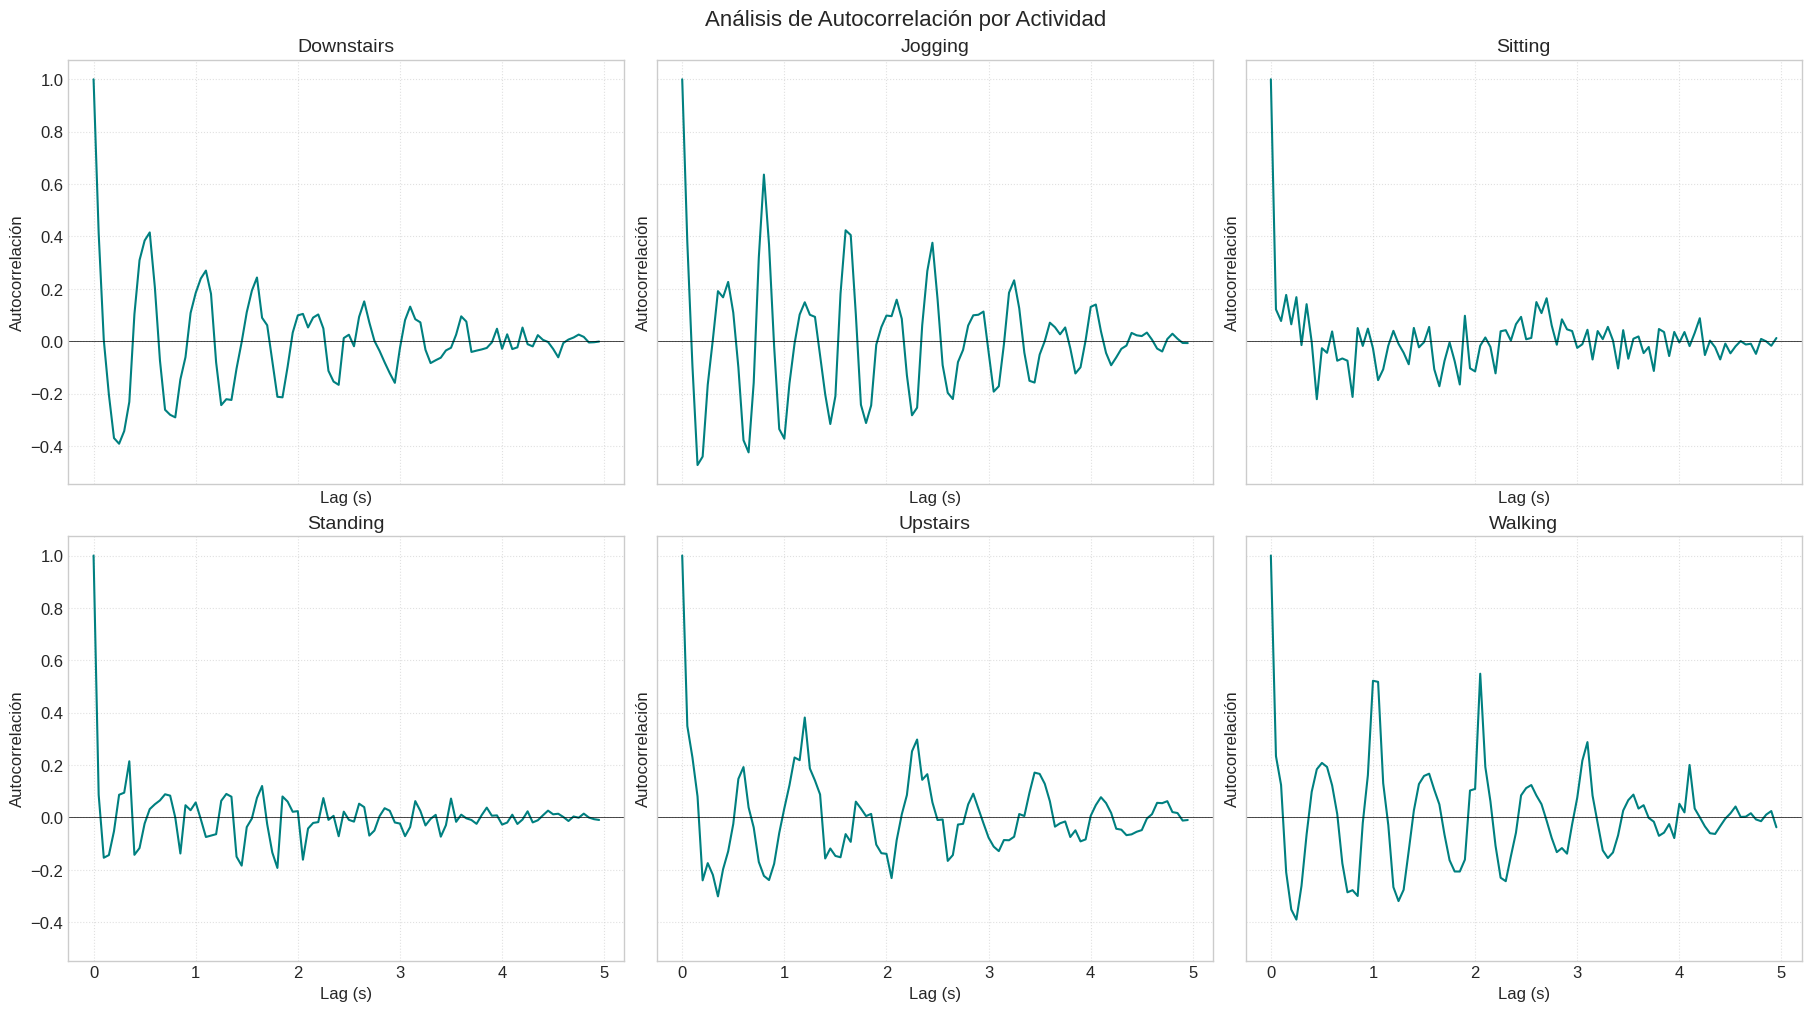

In [64]:
# Autocorrelación para todas las actividades
activities = sorted(train_data['activity'].unique())
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True, constrained_layout=True)
axes = axes.flatten()

for i, act in enumerate(activities):
    # Seleccionar un snippet aleatorio
    snippet = train_data[train_data['activity'] == act]['user_snippet'].sample(1, random_state=SEED).iloc[0]
    subset = train_data[train_data['user_snippet'] == snippet].sort_values('timestamp')
    
    # Calcular SVM y centrar
    svm = np.sqrt(subset['x-axis']**2 + subset['y-axis']**2 + subset['z-axis']**2)
    svm = svm - svm.mean()
    
    # Calcular autocorrelación
    autocorr = np.correlate(svm, svm, mode='full')
    autocorr = autocorr[len(autocorr)//2:] # Mitad positiva
    autocorr = autocorr / autocorr[0] # Normalizar
    
    # Eje de tiempo (lags)
    lags = np.arange(len(autocorr)) / FS
    
    # Graficar
    axes[i].plot(lags, autocorr, color='teal')
    axes[i].set_title(f'{act}')
    axes[i].set_xlabel('Lag (s)')
    axes[i].set_ylabel('Autocorrelación')
    axes[i].grid(True, linestyle=':', alpha=0.6)
    axes[i].axhline(0, color='black', linewidth=0.5)

plt.suptitle('Análisis de Autocorrelación por Actividad', fontsize=16)
plt.savefig('plots/autocorrelation.png')
plt.show()

#### 3.2.4 Entropía Espectral

La entropía espectral es una medida de la complejidad o desorden de la señal en el dominio de la frecuencia.
*   **Baja Entropía:** Indica que la energía se concentra en pocas frecuencias (típico de actividades cíclicas y ordenadas como *Walking*).
*   **Alta Entropía:** Indica que la energía está dispersa en todo el espectro (típico de ruido blanco o actividades estáticas como *Sitting*).

Este indicador es excelente para separar actividades dinámicas de estáticas.

/tmp/ipykernel_1101212/685605680.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_entropy, x='Activity', y='Spectral Entropy', palette="Set2", inner="quartile", linewidth=1)


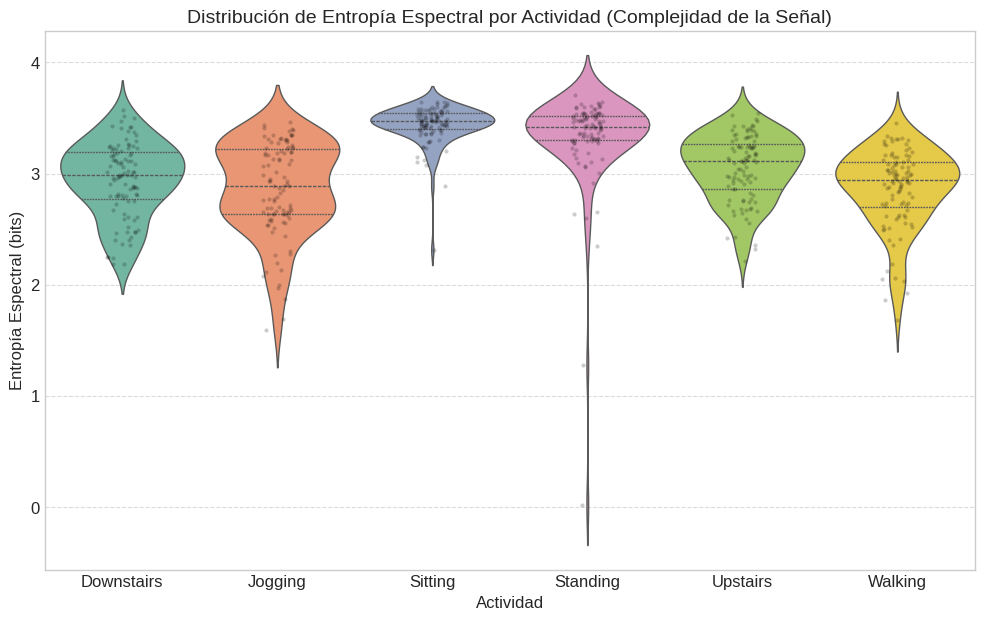

In [65]:
from scipy.stats import entropy

def calculate_spectral_entropy(signal_data, fs):
    # Calcular PSD usando Welch
    f, Pxx = signal.welch(signal_data, fs, nperseg=min(len(signal_data), 256))
    # Normalizar PSD para tratarla como distribución de probabilidad
    psd_norm = Pxx / np.sum(Pxx)
    # Calcular entropía de Shannon
    return entropy(psd_norm)

# Calcular entropía para una muestra de snippets de todas las actividades
entropy_data = []
activities_list = sorted(train_data['activity'].unique())

for activity in activities_list:
    snippets = train_data[train_data['activity'] == activity]['user_snippet'].unique()
    # Muestrear hasta 100 snippets para tener una mejor distribución representativa
    selected = np.random.choice(snippets, min(len(snippets), 100), replace=False)
    
    for snippet in selected:
        subset = train_data[train_data['user_snippet'] == snippet].sort_values('timestamp')
        # Calcular SVM
        svm = np.sqrt(subset['x-axis']**2 + subset['y-axis']**2 + subset['z-axis']**2)
        svm = svm - svm.mean() # Eliminar componente DC
        
        ent = calculate_spectral_entropy(svm, FS)
        entropy_data.append({'Activity': activity, 'Spectral Entropy': ent})

df_entropy = pd.DataFrame(entropy_data)

# Visualización mejorada: Violin Plot + Strip Plot
plt.figure(figsize=(12, 7))
# Violin plot para ver la densidad y cuartiles
# Usamos la paleta cualitativa Set2
sns.violinplot(data=df_entropy, x='Activity', y='Spectral Entropy', palette="Set2", inner="quartile", linewidth=1)
# Strip plot para ver la dispersión de los puntos
sns.stripplot(data=df_entropy, x='Activity', y='Spectral Entropy', color='black', alpha=0.2, size=3, jitter=True)

plt.title('Distribución de Entropía Espectral por Actividad (Complejidad de la Señal)', fontsize=14)
plt.ylabel('Entropía Espectral (bits)')
plt.xlabel('Actividad')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('plots/spectral_entropy.png')
plt.show()

**Nota:** El análisis en el dominio de la frecuencia confirma una clara distinción entre actividades estáticas (*Standing*, *Sitting*) y dinámicas. Mientras que actividades como *Jogging*, *Walking* y subir/bajar escaleras presentan firmas espectrales únicas y bien diferenciadas, el principal desafío radica en distinguir entre *Sitting* y *Standing*. Ambas muestran perfiles de frecuencia muy similares y las características calculadas no revelan diferencias significativas a simple vista; sin embargo, una inspección detallada de los espectrogramas sugiere una densidad espectral ligeramente mayor en *Standing*, lo cual podría ser un factor clave para su clasificación.